<a href="https://colab.research.google.com/github/MazurovaNN/Data-Science/blob/main/lesson8_Timeseries_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Временные ряды

**Временные ряды** - это числовая последовательность на временной оси

Примерами временных рядов являются:
- Выручка магазина по дням
- Изменение цен на акции компании Tesla
- и т.д.


Будем рассматривать задачу на данных об авиаперелетах 50-х годах 20-го века

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

flights = sns.load_dataset('flights')

flights.head(10)

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
5,1949,Jun,135
6,1949,Jul,148
7,1949,Aug,148
8,1949,Sep,136
9,1949,Oct,119


Построим график

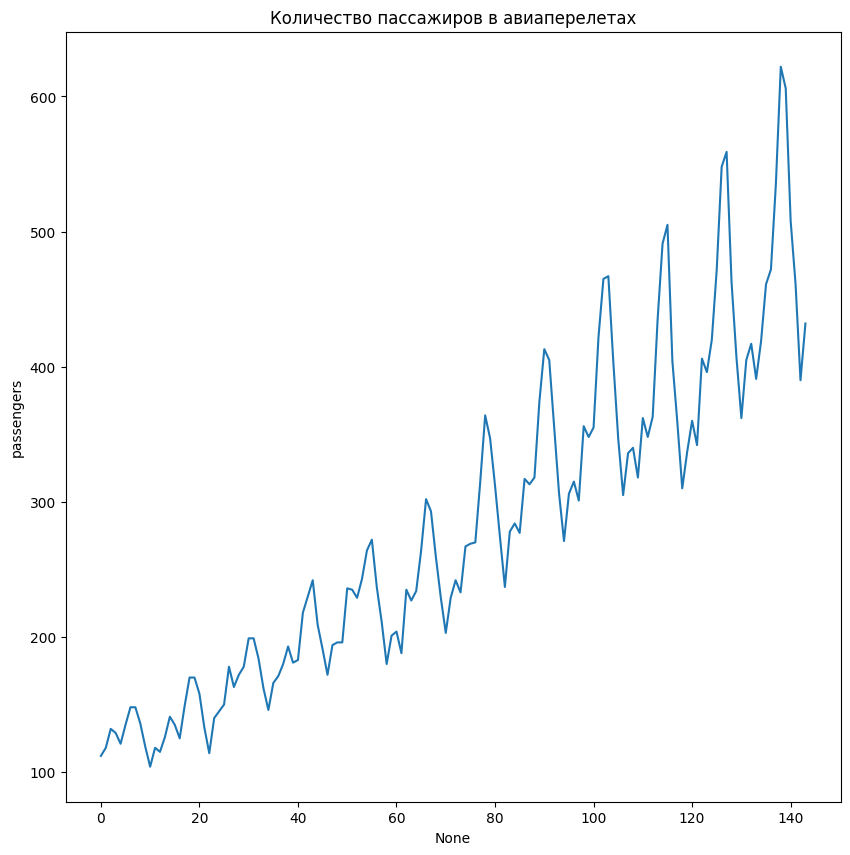

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
sns.lineplot(x = flights.index, y = flights['passengers'])
plt.title('Количество пассажиров в авиаперелетах')
plt.show()

## Скользящее среднее

В `pandas` скользящее среднее рассчитывается при помощи функции `rolling`, в него передается размер окна

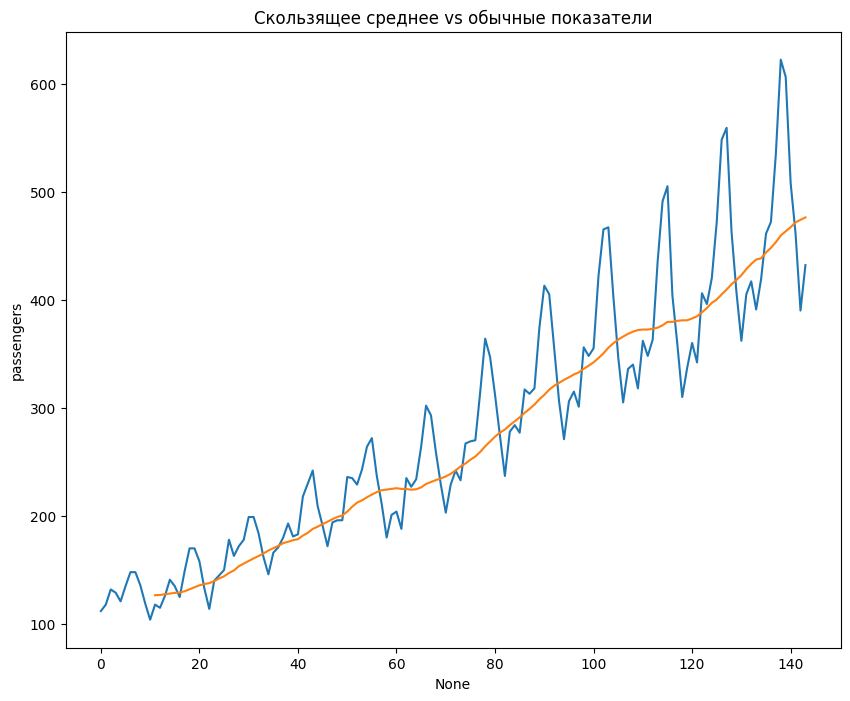

In [3]:
flights['moving_avg'] = flights['passengers'].rolling(12).mean()

plt.figure(figsize = (10, 8))
sns.lineplot(x = flights.index, y = flights['passengers'])
sns.lineplot(x = flights.index, y = flights['moving_avg'])
plt.title('Скользящее среднее vs обычные показатели')
plt.show()

## Библиотека statsmodels. Определение тренда и сезонности

Библиотека `statsmodels` является мощным инструментом для статистического анализа, в т.ч. и временных рядов.
https://www.statsmodels.org/stable/index.html

Как видно из графиков, кол-во пассажиров в авиаперелетах имеет стабильный восходящий тренд и сезонность. Выделим их из данных при помощи функции `seasonal_decompose()` из модуля `tsa` (time-series analysis)

На вход функции подается временной ряд и она возвращает объект со следующими атрибутами:
- trend - тренд
- seasonal - сезонная составляющая ряда
- resid - остаток декомпозиции

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(flights['passengers'], period = 12) # Берем годовой период

decomposed.seasonal

0     -24.748737
1     -36.188131
2      -2.241162
3      -8.036616
4      -4.506313
         ...    
139    62.823232
140    16.520202
141   -20.642677
142   -53.593434
143   -28.619949
Name: seasonal, Length: 144, dtype: float64

## Разность ряда

Иногда для уменьшения колебания ряда можно посчитать разность между соседними элементами. В `pandas` значения предыдущей строки возможно получить при помощи атрибута `shift`

In [5]:
# Вычтем из текущего значения ряда предыдущее
flights['differ'] = flights['passengers'] - flights['passengers'].shift()

flights.head(10)

,year,month,passengers,moving_avg,differ
0,1949,Jan,112,NaN,NaN
1,1949,Feb,118,NaN,6.0
2,1949,Mar,132,NaN,14.0
3,1949,Apr,129,NaN,-3.0
4,1949,May,121,NaN,-8.0
5,1949,Jun,135,NaN,14.0
6,1949,Jul,148,NaN,13.0
7,1949,Aug,148,NaN,0.0
8,1949,Sep,136,NaN,-12.0
9,1949,Oct,119,NaN,-17.0


## Прогнозирование без обучения

Построим грубый прогноз на основе среднего значения за весь период наблюдений

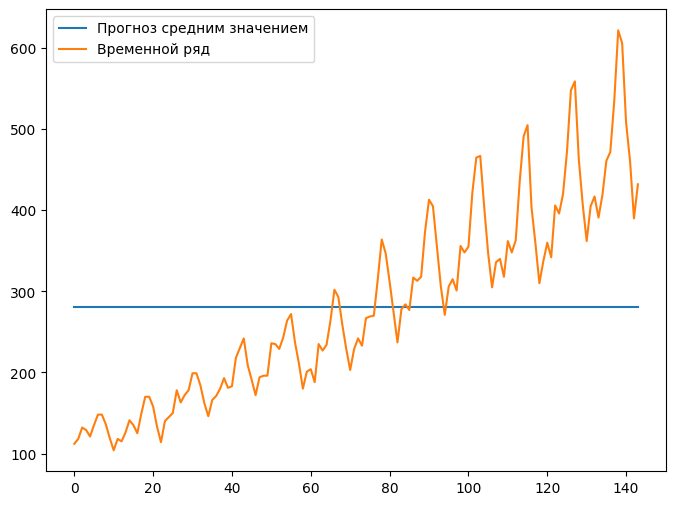

In [6]:
plt.figure(figsize = (8, 6))
plt.plot([flights.index.min(), flights.index.max()],
         [flights['passengers'].mean(), flights['passengers'].mean()],
        label = 'Прогноз средним значением')
plt.plot(flights.index, flights['passengers'], label = 'Временной ряд')
plt.legend()
plt.show()


## Прогнозирование при помощи линейной регрессии

При переводе задачи прогнозирования временного ряда в задачу обучения с учителем следует правильно разделить данные на признаки и целевую переменную.

Целевой переменной в таком случае станет значение ряда в момент времени t, а признаками будут t-n наблюдений предшествующих нему.


Создадим специальную функцию, которая разделяет данные

In [7]:
X = flights[['passengers']]

In [8]:
# Переводит временной ряд в задачу обучения с учителем
def data_loader(data, n_in=12, n_out=1, dropnan=True):
    # Кол-во переменных
    try:
        n_vars = X.shape[1]
    except:
        n_vars = 1
    df = pd.DataFrame(data)
    cols = list()
    # Прогнозируем наблюдение t
    # Входные данные (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # Последовательность для предсказания (t, t+1, ... t+n_out)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # Соединим все вместе
    agg = pd.concat(cols, axis=1)
    # Убираем строки с NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [9]:
X_ = data_loader(X)
print("Данные при первой итерации \n", X_[0])

print("Данные при второй итерации \n", X_[1])

Данные при первой итерации 
 [112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115.]
Данные при второй итерации 
 [118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.]


Функция деления на тестовую и тренировочную выборки

In [10]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [11]:
a, b = train_test_split(X_, 12)
print(a.shape)
print(b.shape)

(120, 13)
(12, 13)


Функция обучения модели линейной регрессии

In [12]:
from sklearn.linear_model import LinearRegression

def forecast(train, testX):
    train = np.asarray(train)
    # Делим тренировочную выборку на входные и выходные данные
    trainX, trainy = train[:, :-1], train[:, -1]
    # Обучаем модель
    model = LinearRegression()
    model.fit(trainX, trainy)
    # Предсказываем на шаг вперед
    yhat = model.predict([testX])
    return yhat[0]


**Почему нельзя использовать стандартную кросс-валидацию?**

Напишем функцию для специальной валидации временных рядов

In [13]:
from sklearn.metrics import mean_absolute_error

# walk-forward validation
def walk_forward_validation(data, n_test):
    predictions = list()
    # Деление на тестовую и тренировочные выборки
    train, test = train_test_split(data, n_test)
    # Задаем исторические данные тренировочной выборкой в начальной итерации
    history = [x for x in train]
    # Проходим по каждому наблюдению в тестовой выборке
    for i in range(len(test)):
        # Делим тестовую выборку на входные и выходные данные
        testX, testy = test[i, :-1], test[i, -1]
        # Обучаем модель на исторических данных и делаем предсказание
        yhat = forecast(history, testX)
        # Сохраняем предсказанное значение
        predictions.append(yhat)
        # Добавляем настоящие данные в исторические
        history.append(test[i])
        # Отчет о прогрессе
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # Ошибка предсказания
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [14]:
walk_forward_validation(X_, 12)

>expected=417.0, predicted=395.3
>expected=391.0, predicted=393.8
>expected=419.0, predicted=424.9
>expected=461.0, predicted=423.5
>expected=472.0, predicted=488.1
>expected=535.0, predicted=506.1
>expected=622.0, predicted=612.7
>expected=606.0, predicted=607.8
>expected=508.0, predicted=532.1
>expected=461.0, predicted=439.6
>expected=390.0, predicted=422.5
>expected=432.0, predicted=421.8


(17.68772041137116,
 array([342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
        417.]),
 [395.34390330785976,
  393.78091005421237,
  424.947705656047,
  423.45083778765996,
  488.07758040346613,
  506.1224601970152,
  612.6793702046145,
  607.8086582054335,
  532.0750053170868,
  439.5909334749867,
  422.52352983248744,
  421.7732395601432])

## Авторегрессионные модели

Математическое представление текущего значения ряда:
$$Y(t) =C+b_1Y(t-1)+b_2Y(t-2)+...+b_n(t-n)+\varepsilon(t)=C+ \sum \limits^{n}_{i=1} b_i \, Y_{t-n} \, + \varepsilon_t,$$

где С - константа, которую чаще всего для простоты принимают равной нулю, n — число ретроспективных значений ряда, учитываемых в модели (порядок модели); bi — коэффициенты (параметры) модели, которые требуется оценить при ее построении; ε(t) — случайная составляющая, отражающая вероятностный характер модели.

Авторегрессионные модели, например ARIMA, являются частью библиотеки `statsmodels`
ARIMA чаще всего задается параметрами порядка $(p, q, d)$ авторегрессии, интегрирования и скользящего среднего соответственно

Подробнее про ARIMA http://www.machinelearning.ru/wiki/index.php?title=ARIMA

In [17]:
import warnings
from statsmodels.tsa.arima_model import ARIMA


warnings.filterwarnings('ignore')
X = flights['passengers'].values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)
# Визуализация
plt.figure(figsize = (10, 8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.
